# Demo: saccade detection
----

This is a demonstration of how we detected saccades.

Dependencies:

- Python 3.5+
- Numpy
- Scipy
- Pandas
- Matplotlib
- sliding1d

**NOTE**: you need to get content of the `04_formatted` data repository populated beforehand, via:

```
$ cd ../01_data/04_formatted
$ gin init
$ find . -name "*.csv" | xargs gin get-content
```

In [1]:
from pathlib import Path
from collections import namedtuple
import math
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle, Polygon
import sliding1d as sliding

import datareader

Load trials from the dataset:

In [2]:
trials    = datareader.load_trials("../01_data/04_formatted")

## 1. Browsing original eye-position data

We use the `left_pupil_normalized_position` and the `right_pupil_normalized_position` columns of the `tracking` table.

In [3]:
subject = 'MLA007518'
session = 'session2019-09-30-001'
xlim    = (9, 17) # in seconds

in_session = [trial for trial in trials if (trial.subject == subject and trial.session == session)]
trial      = in_session[2]

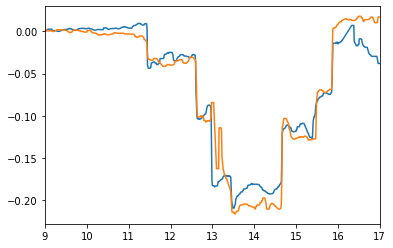

In [4]:
plt.plot(trial.tracking.time, trial.tracking.left_pupil_normalized_position)
plt.plot(trial.tracking.time, trial.tracking.right_pupil_normalized_position)
plt.xlim(xlim)
plt.show()

## 2. Obtaining pupil velocity

1. Pupil positions are smoothed using the sliding-window averaging (almost identical to gaussian-kernel smoothing).
2. The smoothed positions are differentiated, and scaled, to obtain the velocity.

In [5]:
def sliding_diff(x):
    x = np.array(x)
    ret = np.empty(x.size, dtype=np.float64)
    ret[1:-1] = (x[2:] - x[:-2])/2
    ret[0]    = x[1] - x[0]
    ret[-1]   = x[-1] - x[-2]
    return ret

def smoothing_diff(x, rad=5, num=3):
    return sliding_diff(sliding.nanmean(x, rad, num))

dt     = np.diff(trial.tracking.time).mean()
vleft  = smoothing_diff(trial.tracking.left_pupil_normalized_position) / dt
vright = smoothing_diff(trial.tracking.right_pupil_normalized_position) / dt

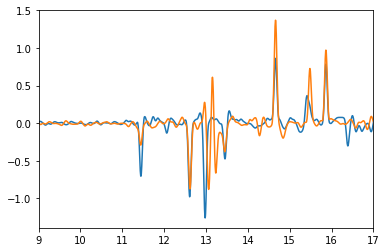

In [6]:
plt.plot(trial.tracking.time, vleft)
plt.plot(trial.tracking.time, vright)
plt.xlim(xlim)
plt.show()

## 3. Perform thresholding

Here we use standard deviation based thresholding, i.e. we detect saccades if the pupil velocity exceeded `5*std`.

We consider the velocity to be "above-threshold", only if both the left and the right pupil velocities exceeded the threshold.

In [7]:
def threshold_values(x, threshold):
    ret = np.array(x, copy=True)
    ret[np.abs(x) < threshold] = 0
    return ret

threshold_left  = vleft[trial.tracking.time.values < 1].std(ddof=1)*5
threshold_right = vright[trial.tracking.time.values < 1].std(ddof=1)*5

print(f" left pupil threshold: {threshold_left:.2f} deg/s")
print(f"right pupil threshold: {threshold_right:.2f} deg/s")

# take above-threshold motions only
vleft_thresholded  = threshold_values(vleft, threshold_left)
vright_thresholded = threshold_values(vright, threshold_right)

# detect as above-threshold position only when both the left and the right pupil velocities
# are above-threhsold.
#
# there are some "negative spikes", possibly due to small unsynchronization of pupil motions
# we take both negative and positive spikes here
vavg = np.sqrt(np.abs(vleft_thresholded*vright_thresholded))

 left pupil threshold: 0.13 deg/s
right pupil threshold: 0.13 deg/s


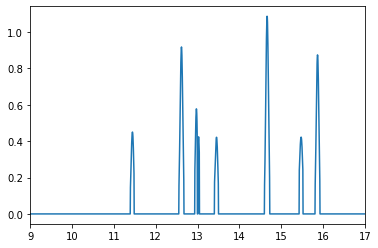

In [8]:
plt.plot(trial.tracking.time, vavg)
plt.xlim(xlim)
plt.show()

## 4. Event detection

- Saccade events can be detected as peaks in the threshold velocity plot (above).
- By taking into account the signature of the velocity, we can determine the direction of saccades.

In [9]:
def get_sign(x):
    return x / np.abs(x)

# parameter configuration for peak detection
# we care about the peaks only when the peak-to-peak distance exceeds 200 ms
min_distance_seconds = 0.2
min_distance_samples = int(round(min_distance_seconds / dt))

print(f"min. peak distance = {min_distance_samples} samples")

peaks  = find_peaks(vavg, distance=min_distance_samples)[0]
sign   = get_sign(vleft_thresholded[peaks]) # leftward if negative, rightward otherwise
events = vavg[peaks] * sign

events # direction + amplitude of the saccades

min. peak distance = 40 samples


array([-0.45002551, -0.91814375, -0.57781147, -0.42164273,  1.0871939 ,
        0.42223875,  0.87461791])

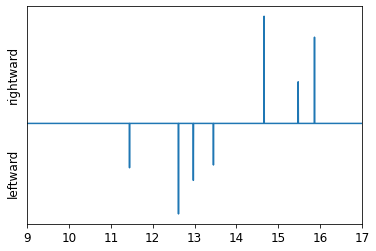

In [10]:
# turning events into samples
saccades = np.zeros(vleft.size, dtype=np.float64)
saccades[peaks] = events

plt.plot(trial.tracking.time, saccades)
plt.xlim(xlim)
plt.yticks((-0.5, 0.5), ("leftward", "rightward"), rotation=90, va='center')
plt.tick_params(labelsize=12, left=False)
plt.show()